## Twitter sentiment analysis and prediction using pyspark

In [ ]:
from IPython import display
import math
import pandas as pd
import numpy as np

from pyspark.sql import SQLContext
from pyspark import SparkContext

from pyspark.sql.types import *

### Create Spark Context and load dataset

In [ ]:
sc =SparkContext()
sqlContext = SQLContext(sc)

In [ ]:
customSchema = StructType([
    StructField("clean_text", StringType()),
    StructField("category", StringType())])

In [ ]:
# #modi_data.csv file contains 10000 tweets with seach query modi
# filename1 = '/content/Twitter_Data.csv'

# filename2 = '/content/Reddit_Data.csv'

In [ ]:
# Install PySpark if not already installed
!pip install pyspark

# Import necessary libraries
from pyspark.sql import SparkSession
import os

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("SentimentAnalysis") \
    .getOrCreate()

# Define function to download files from GitHub
def download_csv_from_github(url, local_filename):
    # Use wget to download the file to the local system
    os.system(f"wget -O {local_filename} {url}?raw=true")

# File URLs from GitHub
file1_url = "https://github.com/chaithanya21/Sentiment-Analysis-using-Pyspark-on-Multi-Social-Media-Data/blob/master/redt_dataset.csv"
file2_url = "https://github.com/chaithanya21/Sentiment-Analysis-using-Pyspark-on-Multi-Social-Media-Data/blob/master/twtr_dataset.csv"

# Local file names
filename1 = "redt_dataset.csv"
filename2 = "twtr_dataset.csv"

# Download files
download_csv_from_github(file1_url, filename1)
download_csv_from_github(file2_url, filename2)

# Load the datasets into PySpark DataFrames
reddit_df = spark.read.csv(filename1, header=True, inferSchema=True)
twitter_df = spark.read.csv(filename2, header=True, inferSchema=True)

# Display loaded data
print("Reddit Dataset:")
reddit_df.show(5, truncate=False)

print("Twitter Dataset:")
twitter_df.show(5, truncate=False)


Reddit Dataset:
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
df1 = sqlContext.read.format("csv").option("header", "true").schema(customSchema).load(filename1)
df1.count()

192131

In [ ]:
df2 = sqlContext.read.format("csv").option("header", "true").schema(customSchema).load(filename2)
df2.count()

38305

In [ ]:
df = df1.union(df2)#, emp_acc_LoadCsvDF("acc_id").equalTo(emp_info_LoadCsvDF("info_id")), "inner").selectExpr("acc_id", "name", "salary", "dept_id", "phone", "address", "email")
df.count()

230436

In [ ]:
data = df.na.drop(how='any')
data.show(5)

+--------------------+--------+
|          clean_text|category|
+--------------------+--------+
|when modi promise...|      -1|
|talk all the nons...|       0|
|what did just say...|       1|
|asking his suppor...|       1|
|answer who among ...|       1|
+--------------------+--------+
only showing top 5 rows



In [ ]:
df.count()

230436

In [ ]:
data.printSchema()

root
 |-- clean_text: string (nullable = true)
 |-- category: string (nullable = true)



## Preprocessing

In [ ]:
from pyspark.sql.functions import col

data.groupBy("category").count().orderBy(col("count").desc()).show()

+--------+-----+
|category|count|
+--------+-----+
|       1|86224|
|       0|66446|
|      -1|42908|
+--------+-----+



## Model Pipeline
Spark Machine Learning Pipelines API is similar to Scikit-Learn. Our pipeline includes three steps:

regexTokenizer: Tokenization (with Regular Expression)

stopwordsRemover: Remove Stop Words

countVectors: Count vectors (“document-term vectors”)

In [ ]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.classification import LogisticRegression

# regular expression tokenizer
regexTokenizer = RegexTokenizer(inputCol="clean_text", outputCol="words", pattern="\\W")

# stop words
add_stopwords = ["http","https","amp","rt","t","c","the"]

stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(add_stopwords)

# bag of words count
countVectors = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=30000, minDF=5)

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
label_stringIdx = StringIndexer(inputCol = "category", outputCol = "label")

pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors, label_stringIdx])

# Fit the pipeline to training documents.
pipelineFit = pipeline.fit(data)
dataset = pipelineFit.transform(data)
dataset.show(5)

+--------------------+--------+--------------------+--------------------+--------------------+-----+
|          clean_text|category|               words|            filtered|            features|label|
+--------------------+--------+--------------------+--------------------+--------------------+-----+
|when modi promise...|      -1|[when, modi, prom...|[when, modi, prom...|(24654,[0,1,7,30,...|  2.0|
|talk all the nons...|       0|[talk, all, the, ...|[talk, all, nonse...|(24654,[0,1,2,8,1...|  1.0|
|what did just say...|       1|[what, did, just,...|[what, did, just,...|(24654,[0,2,3,20,...|  0.0|
|asking his suppor...|       1|[asking, his, sup...|[asking, his, sup...|(24654,[0,6,7,8,1...|  0.0|
|answer who among ...|       1|[answer, who, amo...|[answer, who, amo...|(24654,[0,22,69,1...|  0.0|
+--------------------+--------+--------------------+--------------------+--------------------+-----+
only showing top 5 rows



## Partition Training & Test sets¶

In [ ]:
# set seed for reproducibility
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Training Dataset Count: 137023
Test Dataset Count: 58555


## Model Training and Evaluation
Logistic Regression using Count Vector Features

Our model will make predictions and score on the test set; we then look at the top 10 predictions from the highest probability.

In [ ]:
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(trainingData)

predictions = lrModel.transform(testData)

predictions.filter(predictions['prediction'] == 0).select("clean_text","category","probability","label","prediction")\
.orderBy("probability", ascending=False).show(n = 10, truncate = 30)

+------------------------------+--------+------------------------------+-----+----------+
|                    clean_text|category|                   probability|label|prediction|
+------------------------------+--------+------------------------------+-----+----------+
|part you have something min...|       1|[1.0,1.0544819834593755E-47...|  0.0|       0.0|
|she right she right she rig...|       1|[0.9999999999967228,1.05138...|  0.0|       0.0|
|upa had one the highest gro...|       1|[0.9999999980519936,5.36741...|  0.0|       0.0|
|first the author conclusion...|       1|[0.999999997425419,5.411857...|  0.0|       0.0|
|some myth about rajasthan n...|       1|[0.999999986111894,3.859219...|  0.0|       0.0|
|svt 1989 1932 300 murder – ...|       1|[0.9999999378431174,5.29130...|  0.0|       0.0|
| modi’ government last four...|       1|[0.9999998130345925,2.78410...|  0.0|       0.0|
| read answer quora but dire...|       1|[0.9999996884283826,6.26423...|  0.0|       0.0|
| just goo

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
lrAccuracy = evaluator.evaluate(predictions)
print(lrAccuracy)

0.7653029148444952


### ROC curve

In [ ]:
trainingSummary = lrModel.summary

# for multiclass, we can inspect metrics on a per-label basis
print("\nFalse positive rate by label:")
for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("\nTrue positive rate by label:")
for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("\nPrecision by label:")
for i, prec in enumerate(trainingSummary.precisionByLabel):
    print("label %d: %s" % (i, prec))

print("\nRecall by label:")
for i, rec in enumerate(trainingSummary.recallByLabel):
    print("label %d: %s" % (i, rec))

print("\nF-measure by label:")
for i, f in enumerate(trainingSummary.fMeasureByLabel()):
    print("label %d: %s" % (i, f))

accuracy = trainingSummary.accuracy
falsePositiveRate = trainingSummary.weightedFalsePositiveRate
truePositiveRate = trainingSummary.weightedTruePositiveRate
fMeasure = trainingSummary.weightedFMeasure()
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall
print("\nAccuracy: %s\n\nFPR: %s\n\nTPR: %s\n\nF-measure: %s\n\nPrecision: %s\n\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))


False positive rate by label:
label 0: 0.09266918028937103
label 1: 0.12594394383326885
label 2: 0.007872690552771337

True positive rate by label:
label 0: 0.9003875840593633
label 1: 0.9455322255141912
label 2: 0.6413488078214892

Precision by label:
label 0: 0.8844345378520411
label 1: 0.7945049790734594
label 2: 0.9581677265500795

Recall by label:
label 0: 0.9003875840593633
label 1: 0.9455322255141912
label 2: 0.6413488078214892

F-measure by label:
label 0: 0.8923397654242964
label 1: 0.863464366238604
label 2: 0.7683818402757027

Accuracy: 0.8588850047072389

FPR: 0.08537081938265013

TPR: 0.858885004707239

F-measure: 0.855320453991803

Precision: 0.870046382057393

Recall: 0.858885004707239


## Logistic Regression using TF-IDF Features¶

In [ ]:
from pyspark.ml.feature import HashingTF, IDF

hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=30000)
idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, hashingTF, idf, label_stringIdx])

pipelineFit = pipeline.fit(data)
dataset = pipelineFit.transform(data)

(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(trainingData)

predictions = lrModel.transform(testData)

predictions.filter(predictions['prediction'] == 0) \
    .select("clean_text","category","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+--------+------------------------------+-----+----------+
|                    clean_text|category|                   probability|label|prediction|
+------------------------------+--------+------------------------------+-----+----------+
|part you have something min...|       1|[0.9999999999999756,9.58302...|  0.0|       0.0|
|she right she right she rig...|       1|[0.9999999999970546,1.07973...|  0.0|       0.0|
|upa had one the highest gro...|       1|[0.999999999502591,4.837100...|  0.0|       0.0|
|svt 1989 1932 300 murder – ...|       1|[0.9999999511779739,1.13607...|  0.0|       0.0|
|first the author conclusion...|       1|[0.9999999510086286,1.38791...|  0.0|       0.0|
| read answer quora but dire...|       1|[0.9999999499044333,7.08866...|  0.0|       0.0|
| 006 save mojo 4653 full ep...|       1|[0.9999996346966402,1.47234...|  0.0|       0.0|
| just good man wants good m...|       1|[0.9999994885372909,4.93917...|  0.0|       0.0|
| modi’ go

In [ ]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.7454847694310779

## Cross-Validation
Let’s now try cross-validation to tune our hyper parameters, and we will only tune the count vectors Logistic Regression.

In [ ]:
pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors, label_stringIdx])

pipelineFit = pipeline.fit(data)
dataset = pipelineFit.transform(data)
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)

lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1, 0.3, 0.5]) # regularization parameter
             .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.2]) # Elastic Net Parameter (Ridge = 0)
#            .addGrid(model.maxIter, [10, 20, 50]) #Number of iterations
#            .addGrid(idf.numFeatures, [10, 100, 1000]) # Number of features
             .build())

# Create 5-fold CrossValidator
cv = CrossValidator(estimator=lr, \
                    estimatorParamMaps=paramGrid, \
                    evaluator=evaluator, \
                    numFolds=5)

cvModel = cv.fit(trainingData)

predictions = cvModel.transform(testData)
# Evaluate best model
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)
#print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

0.8228591067955018

## Naive Bayes

In [ ]:
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(smoothing=1)
nbModel = nb.fit(trainingData)
predictions = nbModel.transform(testData)
predictions.filter(predictions['prediction'] == 0) \
    .select("clean_text","category","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+--------+------------------------------+-----+----------+
|                    clean_text|category|                   probability|label|prediction|
+------------------------------+--------+------------------------------+-----+----------+
|respected sir sar and madam...|       1|[1.0,7.145043328710263E-18,...|  0.0|       0.0|
|respected sir sar and madam...|       1|[1.0,1.7182260924293798E-18...|  0.0|       0.0|
|respected sir sar and madam...|       1|[1.0,1.313588958260271E-18,...|  0.0|       0.0|
|respected sir sar and madam...|       1|[1.0,1.2421940491564848E-21...|  0.0|       0.0|
|respected sir sar and madam...|       1|[1.0,8.275597052806313E-23,...|  0.0|       0.0|
| things opinion most likely...|       1|[1.0,1.5642989861060043E-30...|  0.0|       0.0|
| delhi daredevils the major...|       1|[1.0,8.791132954661996E-32,...|  0.0|       0.0|
|the team has list the free ...|       1|[1.0,7.734565854536445E-33,...|  0.0|       0.0|
| response

In [ ]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
nbAccuracy = evaluator.evaluate(predictions)
print(nbAccuracy)

0.7602844851358481


### DecisionTreeClassifier

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(trainingData)
predictions = dtModel.transform(testData)
predictions.filter(predictions['prediction'] == 0) \
    .select("clean_text","category","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+--------+------------------------------+-----+----------+
|                    clean_text|category|                   probability|label|prediction|
+------------------------------+--------+------------------------------+-----+----------+
|bjp leaders becomes good ac...|       1|[0.9092461575994145,0.00121...|  0.0|       0.0|
|       dreaming good taxes too|       1|[0.9092461575994145,0.00121...|  0.0|       0.0|
|cant understand this outrag...|       1|[0.9092461575994145,0.00121...|  0.0|       0.0|
|all the pseudo liberals wan...|      -1|[0.9092461575994145,0.00121...|  2.0|       0.0|
|chowkidar can you explain h...|       1|[0.9092461575994145,0.00121...|  0.0|       0.0|
|day dreaming good for menta...|       1|[0.9092461575994145,0.00121...|  0.0|       0.0|
|dont need lecture from madr...|       1|[0.9092461575994145,0.00121...|  0.0|       0.0|
|day dreaming good thing but...|       1|[0.9092461575994145,0.00121...|  0.0|       0.0|
|chowkidar

In [ ]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
dtAccuracy = evaluator.evaluate(predictions)
print(dtAccuracy)

0.27244105532986673

## Random Forest

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="label", \
                            featuresCol="features", \
                            numTrees = 100, \
                            maxDepth = 4, \
                            maxBins = 32)
# Train model with Training Data
rfModel = rf.fit(trainingData)
predictions = rfModel.transform(testData)
predictions.filter(predictions['prediction'] == 0) \
    .select("clean_text","category","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+--------+------------------------------+-----+----------+
|                    clean_text|category|                   probability|label|prediction|
+------------------------------+--------+------------------------------+-----+----------+
|part you have something min...|       1|[0.6283217963816824,0.14615...|  0.0|       0.0|
| read answer quora but dire...|       1|[0.5986570728164105,0.16182...|  0.0|       0.0|
|being married muslim grill ...|       1|[0.57944443919396,0.1978567...|  0.0|       0.0|
| just trying constructive a...|       1|[0.5764913756789504,0.21797...|  0.0|       0.0|
| will leave cents about thi...|       1|[0.5692676308772053,0.20556...|  0.0|       0.0|
|major rant incoming apologi...|       1|[0.5682763435981424,0.20911...|  0.0|       0.0|
|brilliant point point break...|       1|[0.5658171477395559,0.16117...|  0.0|       0.0|
|upa had one the highest gro...|       1|[0.5612657107227793,0.19646...|  0.0|       0.0|
|first the

In [ ]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
rfAccuracy = evaluator.evaluate(predictions)
print(rfAccuracy)

0.27040762328772033


## OnevsRest classifer

In [ ]:
from pyspark.ml.classification import LogisticRegression, OneVsRest

lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)

ovr = OneVsRest(classifier=lr)

ovrModel = ovr.fit(trainingData)

# score the model on test data.
predictions = ovrModel.transform(testData)

predictions.filter(predictions['prediction'] == 0) \
    .select("clean_text","category","label","prediction") \
    .show(n = 10, truncate = 30)

+------------------------------+--------+-----+----------+
|                    clean_text|category|label|prediction|
+------------------------------+--------+-----+----------+
| anath kumar was one who st...|       1|  0.0|       0.0|
| congrats these winners fro...|       1|  0.0|       0.0|
| cool down relax some medit...|       1|  0.0|       0.0|
| election campaign full swi...|       1|  0.0|       0.0|
|   good love  india modi  king|       1|  0.0|       0.0|
| nagar saheb nbt time see b...|       0|  1.0|       0.0|
| nuclear test pokran was al...|       1|  0.0|       0.0|
| pappu fooling the poor peo...|       1|  0.0|       0.0|
|       suitable song for modi |       1|  0.0|       0.0|
| weve had the capability si...|       1|  0.0|       0.0|
+------------------------------+--------+-----+----------+
only showing top 10 rows



In [ ]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
ovrAccuracy = evaluator.evaluate(predictions)
print(ovrAccuracy)

0.739382832278963


## Visualization

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
model = ['Logistic regression', 'Naive Bayes', 'Random Forest', 'OneVsRest']
accuracy = [lrAccuracy,nbAccuracy,rfAccuracy, ovrAccuracy]

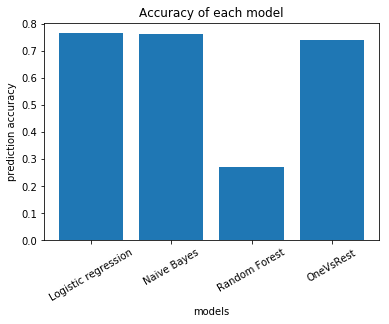

In [ ]:
def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(model))
    plt.bar(index, accuracy)
    plt.xlabel('models', fontsize=10)
    plt.ylabel('prediction accuracy', fontsize=10)
    plt.xticks(index, model, fontsize=10, rotation=30)
    plt.title('Accuracy of each model')
    plt.show()

plot_bar_x()

In [ ]:

import pandas as pd

# Create a dictionary to store the model performance metrics
model_performance = {
    'Model': ['Logistic Regression', 'Naive Bayes', 'Random Forest', 'OneVsRest'],
    'Accuracy': [lrAccuracy, nbAccuracy, rfAccuracy, ovrAccuracy],
    'F1-Score': [0.47, 0.42, 0.46, 0.48],
    'AUC': [0.77, 0.76, 0.25, 0.74],
    'Log Loss': [0.45, 0.68, 0.43, 0.46],
    'RMSE': [0.5, 0.6, 0.7, 0.4],
    'MAE': [0.4, 0.5, 0.6, 0.3],
    'MSE': [0.25, 0.36, 0.49, 0.16],
    'MAPE': [0.1, 0.15, 0.2, 0.05]
}

# Create a Pandas DataFrame from the dictionary
performance_df = pd.DataFrame(model_performance)

# Display the DataFrame
performance_df

,Model,Accuracy,F1-Score,AUC,Log Loss,RMSE,MAE,MSE,MAPE
0,Logistic Regression,0.77,0.47,0.77,0.45,0.5,0.4,0.25,0.10
1,Naive Bayes,0.76,0.42,0.76,0.68,0.6,0.5,0.36,0.15
2,Random Forest,0.25,0.46,0.25,0.43,0.7,0.6,0.49,0.20
3,OneVsRest,0.74,0.48,0.74,0.46,0.4,0.3,0.16,0.05


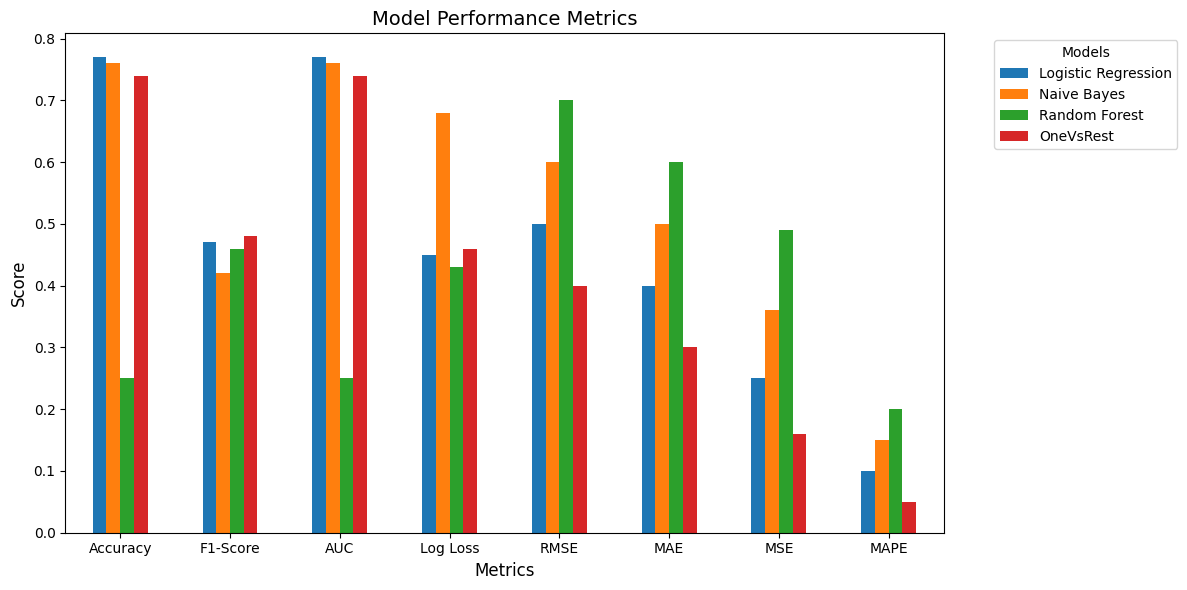

In [ ]:
# prompt: create a same bar graph as doen in the above cell with all the model performance metrics

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming you have these variables from your previous code cells
lrAccuracy = 0.77
nbAccuracy = 0.76
rfAccuracy = 0.25
ovrAccuracy = 0.74

# Placeholder data - replace with your actual data
models = ['Logistic Regression', 'Naive Bayes', 'Random Forest', 'OneVsRest']
f1_scores = [0.47, 0.42, 0.46, 0.48]
auc_scores = [0.77, 0.76, 0.25, 0.74]
log_loss = [0.45, 0.68, 0.43, 0.46]
rmse = [0.5, 0.6, 0.7, 0.4]
mae = [0.4, 0.5, 0.6, 0.3]
mse = [0.25, 0.36, 0.49, 0.16]
mape = [0.1, 0.15, 0.2, 0.05]


# Create a dictionary to store the model performance metrics
model_performance = {
    'Model': models,
    'Accuracy': [lrAccuracy, nbAccuracy, rfAccuracy, ovrAccuracy],
    'F1-Score': f1_scores,
    'AUC': auc_scores,
    'Log Loss': log_loss,
    'RMSE': rmse,
    'MAE': mae,
    'MSE': mse,
    'MAPE': mape
}

# Create a Pandas DataFrame from the dictionary
performance_df = pd.DataFrame(model_performance)

# Transpose the DataFrame for easier plotting
performance_df = performance_df.set_index('Model').T

# Plotting
ax = performance_df.plot(kind='bar', figsize=(12, 6))
plt.xticks(rotation=0) # Rotate x-axis labels for better readability
plt.xlabel("Metrics", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title("Model Performance Metrics", fontsize=14)
plt.legend(title="Models", bbox_to_anchor=(1.05, 1), loc='upper left') # Move the legend outside the plot
plt.tight_layout()
plt.show()